<h1>DSCI 552 Homework 8</h1>

Name: Mike Gee\
Github Username: mpg05883\
USC ID: 6845465208\
Due Date: ```July 15th, 2024 at 11:59pm```

<hr>

**Table of contents**<a id='toc0_'></a>    
- [Supervised, Semi-Supervised, and Unsupervised Learning](#toc1_1_)    
    - [(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set](#toc1_1_1_)    
    - [(b) Monte-Carlo Simulation](#toc1_1_2_)    
      - [(i) Supervised Learning](#toc1_1_2_1_)    
        - [Training Set](#toc1_1_2_1_1_)    
        - [Test Set](#toc1_1_2_1_2_)    
      - [(ii) Semi-Supervised Learning/ Self-training](#toc1_1_2_2_)    
        - [Training Set](#toc1_1_2_2_1_)    
        - [Test Set](#toc1_1_2_2_2_)    
      - [(iii) Unsupervised Learning](#toc1_1_2_3_)    
        - [Training Set](#toc1_1_2_3_1_)    
        - [Test Set](#toc1_1_2_3_2_)    
      - [(iv) Spectral Clustering](#toc1_1_2_4_)    
        - [Training Set](#toc1_1_2_4_1_)    
        - [Test Set](#toc1_1_2_4_2_)    
      - [(iv) Compare](#toc1_1_2_5_)    
  - [Active Learning Using Support Vector Machines](#toc1_2_)    
    - [(a) Download the banknote authentication Data Set](#toc1_2_1_)    
    - [(b) Repeat each of the following two procedures 50 times](#toc1_2_2_)    
      - [(i) Passive](#toc1_2_2_1_)    
      - [(ii) Active](#toc1_2_2_2_)    
    - [(c) Average the 50 test errors](#toc1_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Supervised, Semi-Supervised, and Unsupervised Learning](#toc0_)

Import packages

In [1]:
import pandas as pd
import numpy as np
import warnings
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.svm import LinearSVC
from IPython.display import display, Markdown
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_curve,
                             auc,
                             RocCurveDisplay)
from sklearn.cluster import KMeans, SpectralClustering

### <a id='toc1_1_1_'></a>[(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set](#toc0_)

Download the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic). Each sample contains 
- an ID
- a class (Benign = B, Malignant = M)
- 30 attributes

Generate column labels.

In [2]:
names = ['id', 'diagnosis']

attributes = ['radius',
              'texture',
              'perimeter',
              'area',
              'smoothness',
              'compactness',
              'concavity',
              'concave_points',
              'symmetry',
              'fractal_dimension']

for num in range(1, 4):
    for attribute in attributes:
        names.append(f'{attribute}{num}')

Read in dataset.

In [3]:
df = pd.read_csv(filepath_or_buffer='../data/wdbc.data', names=names)

# encode classes 'B' and 'M' with ordinal numbers 0 and 1
enc = OrdinalEncoder(categories=[['B', 'M']], dtype=int)
df['diagnosis'] = enc.fit_transform(df[['diagnosis']])

df.head()

,id,diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
assert(df.shape == (569, 32))

### <a id='toc1_1_2_'></a>[(b) Monte-Carlo Simulation](#toc0_)

Repeat the following procedures for
1. supervised learning
2. unsupervised learning
3. semi-supervised learning

$M = 30$ times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set).

- Helper function to generate a balanced random train and test split.

In [5]:
def balanced_rand_split(df: pd.DataFrame, test_size: float):
    # split dataframe into class 0 samples and class 1 samples
    class_0_df = df.loc[df['diagnosis'] == 0]
    class_1_df = df.loc[df['diagnosis'] == 1]

    # randomly select (test_size)% of the class 0 samples and (test_size)% of
    # the class 1 samples
    class_0_test = class_0_df.sample(frac=test_size)
    class_1_test = class_1_df.sample(frac=test_size)

    # get the indices of the test samples
    class_0_test_indices = class_0_test.index.to_list()
    class_1_test_indices = class_1_test.index.to_list()

    # save the remaining (1 - test_size)% of class 0 samples and
    # (1 - test_size)% class 1 samples for the training set
    class_0_train = class_0_df.drop(index=class_0_test_indices)
    class_1_train = class_1_df.drop(index=class_1_test_indices)

    # combine class 0 and class 1 observations to create training and test sets
    training_set = pd.concat([class_0_train, class_1_train], ignore_index=True)
    test_set = pd.concat([class_0_test, class_1_test], ignore_index=True)
    
    return training_set, test_set

Then compare the average 
- accuracy
- precision
- recall
- $F_1$-score
- AUC
  
obtained from each algorithm.

#### <a id='toc1_1_2_1_'></a>[(i) Supervised Learning](#toc0_)

- Helper function to perform 5-fold cross-validation to find the $L_1$ penalty $C$.

In [6]:
def find_L1_penalty(estimator, X, y): 
    # define parameters to search
    param_grid = {'C': np.geomspace(0.1, 1000, num=5)}
    
    # perform grid search cross-validation
    clf = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
    clf.fit(X, y)
    
    # return L1 penalty 
    return clf.best_params_['C']

- Helper function to calculate accuracy, precision, recall, $F_1$-score, and AUC.

In [7]:
def calculate_metrics(y_true: pd.Series, y_pred: pd.Series):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = None
    try:
        roc_auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        roc_auc = 0
    return accuracy, precision, recall, f1, roc_auc

Split data into training set and test set.

In [8]:
training_set, test_set = balanced_rand_split(df=df, test_size=0.2)

# split training and test sets into features and responses
y_train = training_set['diagnosis']
X_train = training_set.drop('diagnosis', axis='columns')
y_test = test_set['diagnosis']
X_test = test_set.drop('diagnosis', axis='columns')

# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [9]:
assert(X_train.shape == (456, 31))
assert(y_train.shape == (456,))
assert(X_test.shape == (113, 31))
assert(y_test.shape == (113,))

1. Train an $L_1$-penalized SVM to classify the data.
2. Use 5-fold cross-validation to choose the penalty parameter. Use normalized data.
3. Report the average accuracy, precision, recall, $F_1$-score, and AUC for both training and test sets over your $M$ runs.
4. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [10]:
warnings.filterwarnings("ignore")

clf, y_pred_train, y_pred_test = (None, )*3

# save metrics from train and test sets
columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
train_metrics, test_metrics = (pd.DataFrame(columns=columns), )*2

for i in range(30):
    # use 5-fold cross-validation to find L1 penalty
    C = find_L1_penalty(LinearSVC(penalty='l1', dual=False), X_train, y_train)
    
    # train L1 penalized SVM. use penalty found from 5-fold cross-validation
    clf = LinearSVC(penalty='l1', dual=False, C=C)
    clf.fit(X_train, y_train)
    
    # predict training set's response
    y_pred_train = clf.predict(X_train)
    
    # calculate training set's metrics
    accuracy, precision, recall, f1, roc_auc = calculate_metrics(y_train,
                                                                 y_pred_train)
    
    # add new row to train_metrics
    new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
                           columns=columns)
    train_metrics = pd.concat([train_metrics, new_row], ignore_index=True)
    
    # predict test set's response
    y_pred_test = clf.predict(X_test)
    
    # calculate test set's metrics
    accuracy, precision, recall, f1, roc_auc = calculate_metrics(y_test,
                                                                 y_pred_test)
    
    # add new row to test_metrics
    new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
                             columns=columns)
    test_metrics = pd.concat([test_metrics, new_row], ignore_index=True)

# display averages of each metric for test and train sets
averages_dict = {'Accuracy' : (train_metrics['accuracy'].mean(), 
                               test_metrics['accuracy'].mean()), 
                 'Precision' : (train_metrics['precision'].mean(), 
                               test_metrics['precision'].mean()),
                 'Recall' : (train_metrics['recall'].mean(), 
                               test_metrics['recall'].mean()),
                 'F1-Score' : (train_metrics['f1_score'].mean(), 
                               test_metrics['f1_score'].mean()),
                 'AUC' :      (train_metrics['roc_auc'].mean(), 
                               test_metrics['roc_auc'].mean())}
averages_df = pd.DataFrame(data=averages_dict, index=['Train', 'Test'])
averages_df.round(2)

,Accuracy,Precision,Recall,F1-Score,AUC
Train,0.98,0.99,0.97,0.98,0.98
Test,0.99,1.00,0.98,0.99,0.99


##### <a id='toc1_1_2_1_1_'></a>[Training Set](#toc0_)

- Helper function to plot confusion matrix.

In [11]:
def plot_confusion_matrix(y_true, y_pred, dataset: str, learning: str):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
    disp.plot()
    plt.title(f'{dataset} Set Confusion Matrix ({learning})')
    plt.show()

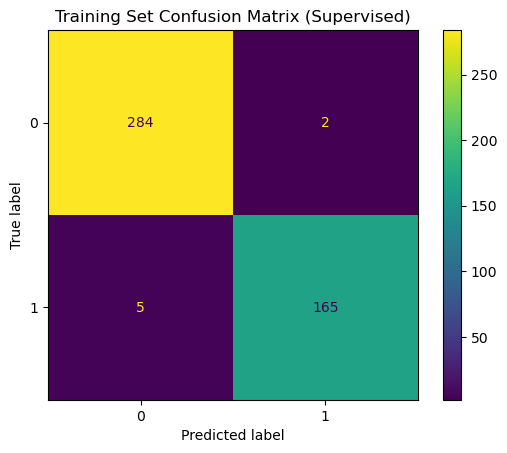

In [12]:
plot_confusion_matrix(y_train, y_pred_train, dataset='Training',
                      learning='Supervised')

- Helper function to plot ROC Curve.

In [13]:
def plot_roc_curve(y_true, y_pred, dataset: str, learning: str):
    """
    I used the code from Scikit-Learn's documentation to generate the ROC Curve:
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.title(f'{dataset} Set ROC Curve ({learning})')
    plt.show()

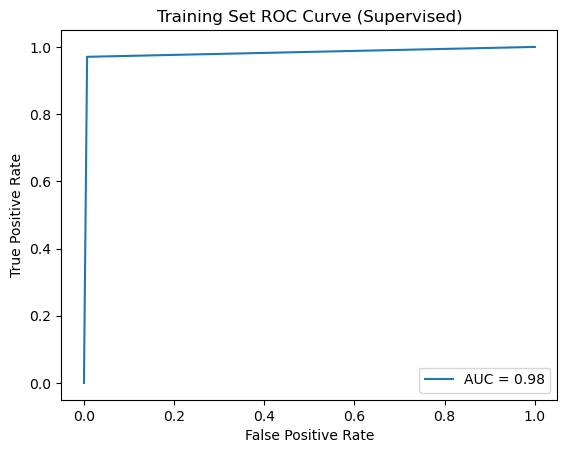

In [14]:
plot_roc_curve(y_train, y_pred_train, dataset='Training', 
               learning='Supervised')

##### <a id='toc1_1_2_1_2_'></a>[Test Set](#toc0_)

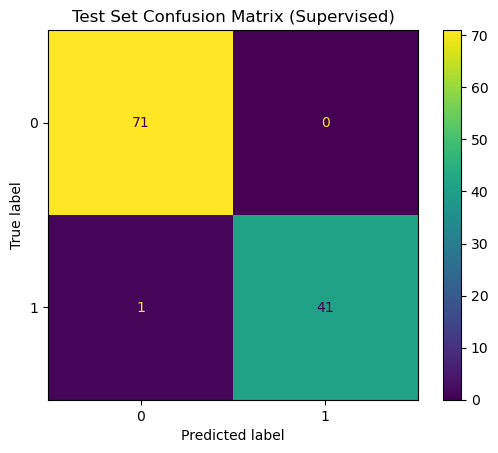

In [15]:
plot_confusion_matrix(y_test, y_pred_test, dataset='Test', 
                      learning='Supervised')

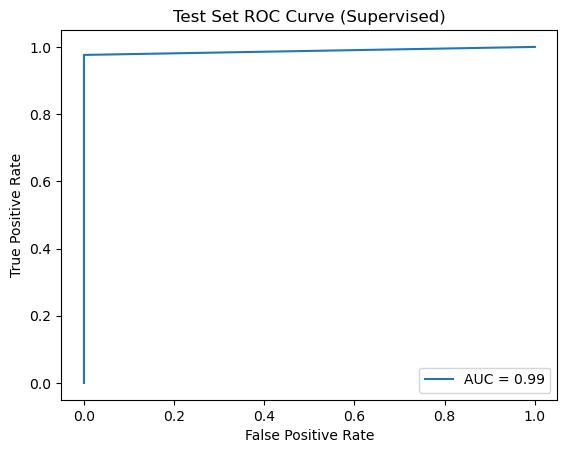

In [16]:
plot_roc_curve(y_test, y_pred_test, dataset='Test', learning='Supervised')

#### <a id='toc1_1_2_2_'></a>[(ii) Semi-Supervised Learning/ Self-training](#toc0_)

Select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabeled data. You can select them randomly.

In [17]:
labeled_set, unlabeled_set = balanced_rand_split(df=training_set,
                                                 test_size=0.5)

# split labeled and unlabeled sets into features and response
y_labeled = labeled_set['diagnosis']
X_labeled = labeled_set.drop('diagnosis', axis='columns')
X_unlabeled = unlabeled_set.drop('diagnosis', axis='columns')

# standardize features
X_labeled = scaler.fit_transform(X_labeled)
X_unlabeled = scaler.fit_transform(X_unlabeled)

In [18]:
assert(X_labeled.shape == (math.ceil(456 / 2), 31))
assert(y_labeled.shape == ((math.ceil(456 / 2),)))
assert(X_unlabeled.shape == (math.floor(456 / 2), 31))

- Helper function to calculate the distance of data point from an SVM's decision boundary.

In [19]:
"""
I referenced this Stack Overflow post to calculate the distance of a data point
from an SVM's decision boundary:
https://stackoverflow.com/questions/32074239/sklearn-getting-distance-of-each-point-from-decision-boundary
"""
def decision_boundary_dist(clf, X):
    y = clf.decision_function(np.reshape(X, (1, -1)))
    w_norm = np.linalg.norm(clf.coef_)
    return y / w_norm

- Helper function to get the data point farthest from the decision boundary.

In [20]:
def get_farthest_data_point(clf, X_unlabeled):
    max_distance = -math.inf
    farthest_data_point = None
    farthest_data_point_index = None
    
    for i in range(len(X_unlabeled)):
        X = X_unlabeled[i]
        db_distance = decision_boundary_dist(clf, X)
        if db_distance > max_distance:
            farthest_data_point = X
            farthest_data_point_index = i
            
    return farthest_data_point, farthest_data_point_index

1. Train an $L_1$-penalized SVM to classify the data.
2. Use 5-fold cross-validation to choose the penalty parameter. Use normalized data.
3. Find the unlabeled data point that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used.
4. Report the average accuracy, precision, recall, $F_1$-score, and AUC for both training and test sets over your $M$ runs.
5. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [21]:
warnings.filterwarnings("ignore")

clf, y_pred_train, y_pred_test = (None, )*3

# save metrics from labeled and unlabeled sets
columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
train_metrics, test_metrics = (pd.DataFrame(columns=columns), )*2

for i in range(30):
    # predict labels for all unlabeled data
    while len(X_unlabeled) != 0:
        # use 5-fold cross-validation to find L1 penalty
        C = find_L1_penalty(LinearSVC(penalty='l1', dual=False),
                            X_labeled, y_labeled)
        
        # train L1-penalized SVM on labeled set
        clf = LinearSVC(penalty='l1', dual=False, C=C)
        clf.fit(X_labeled, y_labeled)

        # find the unlabeled data point farthest from the decision boundary
        X, X_index = get_farthest_data_point(clf, X_unlabeled)
        X = np.reshape(X, (1, -1))
        
        # remove farthest sample from unlabeled dataset
        X_unlabeled = np.delete(X_unlabeled, X_index, axis=0)
        
        # predict label for unlabeled sample
        y_pred = clf.predict(X)
        
        # add newly labeled sample and response to labeled features & response
        X_labeled = np.concatenate((X_labeled, X), axis=0)
        y_labeled = np.concatenate((y_labeled, y_pred), axis=0)
    
    # test final SVM on training and test sets
    clf = LinearSVC(penalty='l1', dual=False, C=C)
    clf.fit(X_train, y_train)
    
    # predict training set's response
    y_pred_train = clf.predict(X_train)
    
    # calculate training set's metrics
    accuracy, precision, recall, f1, roc_auc = calculate_metrics(y_train,
                                                                 y_pred_train)
    
    # add new row to train_metrics
    new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
                           columns=columns)
    train_metrics = pd.concat([train_metrics, new_row], ignore_index=True)
    
    # predict test set's response
    y_pred_test = clf.predict(X_test)
    
    # calculate test set's metrics
    accuracy, precision, recall, f1, roc_auc = calculate_metrics(y_test,
                                                                 y_pred_test)
    
    # add new row to test_metrics
    new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
                             columns=columns)
    test_metrics = pd.concat([test_metrics, new_row], ignore_index=True)

# display averages of each metric for test and train sets
averages_dict = {'Accuracy' : (train_metrics['accuracy'].mean(), 
                               test_metrics['accuracy'].mean()), 
                 'Precision' : (train_metrics['precision'].mean(), 
                               test_metrics['precision'].mean()),
                 'Recall' : (train_metrics['recall'].mean(), 
                               test_metrics['recall'].mean()),
                 'F1-Score' : (train_metrics['f1_score'].mean(), 
                               test_metrics['f1_score'].mean()),
                 'AUC' :      (train_metrics['roc_auc'].mean(), 
                               test_metrics['roc_auc'].mean())}
averages_df = pd.DataFrame(data=averages_dict, index=['Train', 'Test'])
averages_df.round(2)

,Accuracy,Precision,Recall,F1-Score,AUC
Train,0.98,0.99,0.97,0.98,0.98
Test,0.99,1.00,0.98,0.99,0.99


##### <a id='toc1_1_2_2_1_'></a>[Training Set](#toc0_)

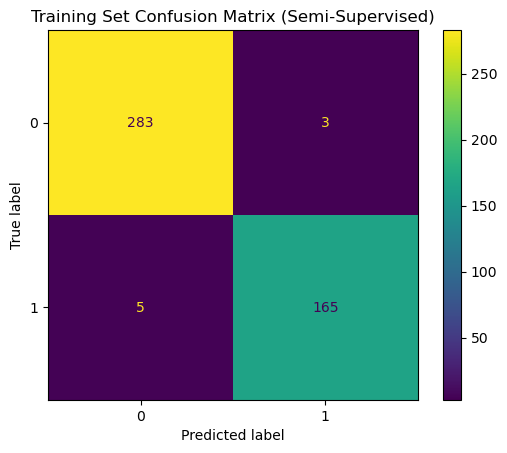

In [22]:
plot_confusion_matrix(y_train, y_pred_train, dataset='Training',
                      learning='Semi-Supervised')

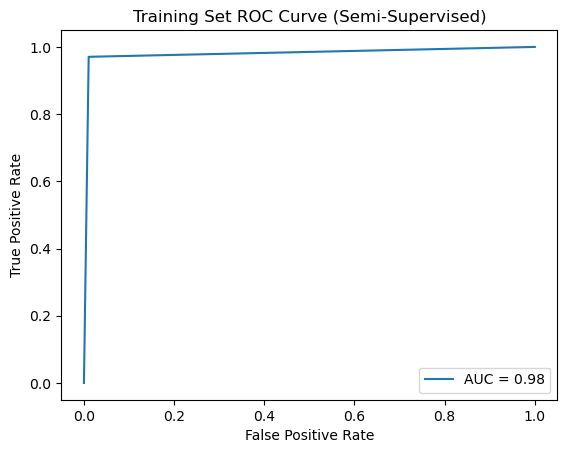

In [23]:
plot_roc_curve(y_train, y_pred_train, dataset='Training',
               learning='Semi-Supervised')

##### <a id='toc1_1_2_2_2_'></a>[Test Set](#toc0_)

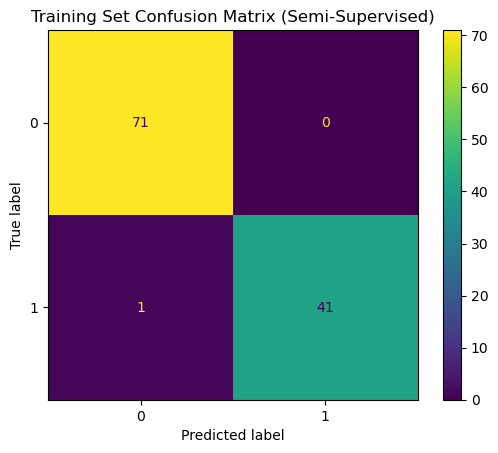

In [24]:
plot_confusion_matrix(y_test, y_pred_test, dataset='Training',
                      learning='Semi-Supervised')

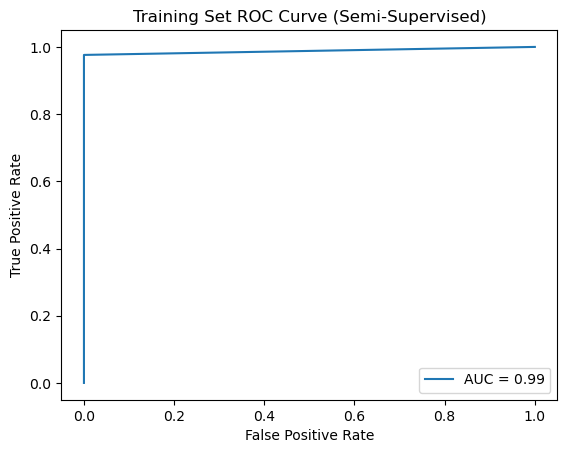

In [25]:
plot_roc_curve(y_test, y_pred_test, dataset='Training',
               learning='Semi-Supervised')

#### <a id='toc1_1_2_3_'></a>[(iii) Unsupervised Learning](#toc0_)

Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume $k$ = 2.

- Helper functions for K-Means Clustering.

In [26]:
""" 
I used the function in this stackoverflow post to find the indices of all samples in a given cluster:
https://stackoverflow.com/questions/36195457/how-to-get-the-samples-in-each-cluster
""" 
def get_cluster_indices(cluster_index: int, cluster_labels: np.ndarray) -> np.ndarray:
    return np.where(cluster_labels == cluster_index)[0]

1. Run the k-means algorithm multiple times. Make sure that you initialize the algorithm randomly. How do you make sure that the algorithm was not trapped in a local minimum?
   1. answer
2. Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, $F_1$-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.
3. Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

In [27]:
k = 2  # assume number of clusters is 2
clf, y_pred_train, y_pred_test = (None, )*3

columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
train_metrics, test_metrics = (pd.DataFrame(columns=columns), )*2

for i in range(30):
     # randomly initialize k means algorithm 
    kmeans = KMeans(n_clusters=k, init='random')
    
    # predict training set's response
    y_pred_train = kmeans.fit_predict(X_train)
    
    # calculate training set's metrics
    (accuracy,
    precision,
    recall,
    f1,
    roc_auc) = calculate_metrics(y_train, y_pred_train)
    
    # add new row to train_metrics
    new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
                            columns=columns)
    train_metrics = pd.concat([train_metrics, new_row], ignore_index=True)
    
    # predict test set's metrics
    y_pred_test = kmeans.predict(X_test)
    
    # calculate training set's metrics
    (accuracy,
    precision,
    recall,
    f1,
    roc_auc) = calculate_metrics(y_test, y_pred_test)
    
    # add new row to train_metrics
    new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
                            columns=columns)
    test_metrics = pd.concat([test_metrics, new_row], ignore_index=True)
        
    # # randomly initialize k means algorithm and fit to training set
    # kmeans = KMeans(n_clusters=k, init='random')
    # kmeans.fit(X_train)
        
    # # get cluster labels of each sample
    # cluster_labels = kmeans.labels_
    
    # # for each cluster:
    # for cluster_index in range(k):
    #     # get indices of all samples in current cluster
    #     cluster_indices = get_cluster_indices(cluster_index, cluster_labels)
        
    #     # get all samples in current cluster
    #     cluster_samples = X_train[cluster_indices]
        
    #     # get distance between each sample and the centroid
    #     distances = kmeans.transform(cluster_samples)
        
    #     # distance from centroid : index
    #     distance_to_index = {}
    #     for i, distance in enumerate(distances):
    #         distance_to_index[np.linalg.norm(distance)] = cluster_indices[i]
            
    #     """
    #     I referenced this article for sorting my dict by keys:
    #     https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
    #     """
    #     keys = list(distance_to_index.keys())
    #     keys = keys[:29]  # get the 30 closest samples to the centroid
    #     keys.sort()
    #     sorted_distance_to_index = {i : distance_to_index[i] for i in keys}
        
    #     # indices of 30 closest samples to the centroid
    #     closest_indices = sorted_distance_to_index.values()
        
    #     # use majority polling to predict the cluster's label
    #     pred_label = y_train[closest_indices].mode()[0]
    #     y_pred_train = pd.Series(data=np.full(shape=y_train[cluster_indices].shape,
    #                                           fill_value=pred_label),
    #                              index=y_train[cluster_indices].index)
        
    #     # calculate training set's metrics
    #     (accuracy,
    #      precision,
    #      recall,
    #      f1,
    #      roc_auc) = calculate_metrics(y_train[cluster_indices], y_pred_train)
        
    #     # add new row to train_metrics
    #     new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
    #                             columns=columns)
    #     train_metrics = pd.concat([train_metrics, new_row], ignore_index=True)
        
    #     # predict test set's response
    #     y_pred_test = kmeans.predict(X_test)
        
    #     # calculate test set's metrics
    #     (accuracy,
    #      precision,
    #      recall,
    #      f1,
    #      roc_auc) = calculate_metrics(y_test, y_pred_test)
        
    #     # add new row to test_metrics
    #     new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
    #                             columns=columns)
    #     test_metrics = pd.concat([test_metrics, new_row], ignore_index=True)
        
# display averages of each metric for test and train sets
averages_dict = {'Accuracy' : (train_metrics['accuracy'].mean(), 
                               test_metrics['accuracy'].mean()), 
                 'Precision' : (train_metrics['precision'].mean(), 
                               test_metrics['precision'].mean()),
                 'Recall' : (train_metrics['recall'].mean(), 
                               test_metrics['recall'].mean()),
                 'F1-Score' : (train_metrics['f1_score'].mean(), 
                               test_metrics['f1_score'].mean()),
                 'AUC' :      (train_metrics['roc_auc'].mean(), 
                               test_metrics['roc_auc'].mean())}
averages_df = pd.DataFrame(data=averages_dict, index=['Train', 'Test'])
averages_df.round(2)

,Accuracy,Precision,Recall,F1-Score,AUC
Train,0.36,0.37,0.39,0.37,0.37
Test,0.37,0.38,0.40,0.38,0.38


##### <a id='toc1_1_2_3_1_'></a>[Training Set](#toc0_)

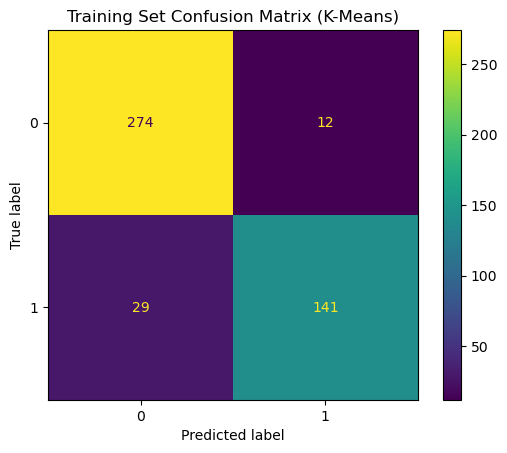

In [28]:
plot_confusion_matrix(y_train, y_pred_train,
                      dataset='Training', learning='K-Means')

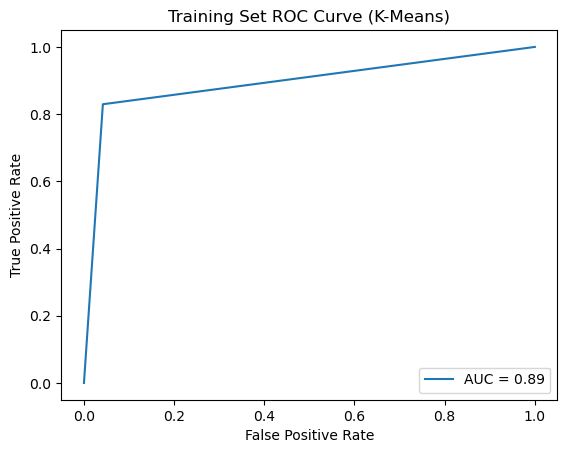

In [29]:
plot_roc_curve(y_train, y_pred_train, dataset='Training', 
               learning='K-Means')

##### <a id='toc1_1_2_3_2_'></a>[Test Set](#toc0_)

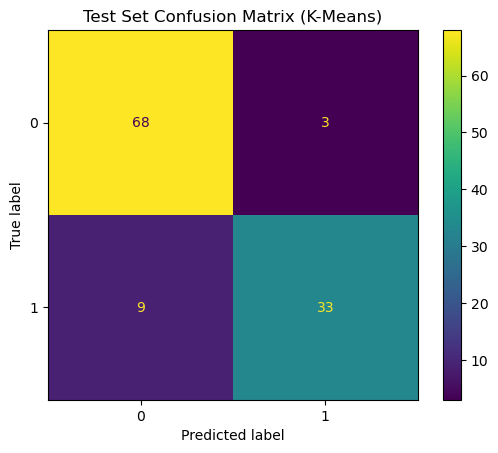

In [30]:
plot_confusion_matrix(y_test, y_pred_test, dataset='Test', 
                      learning='K-Means')

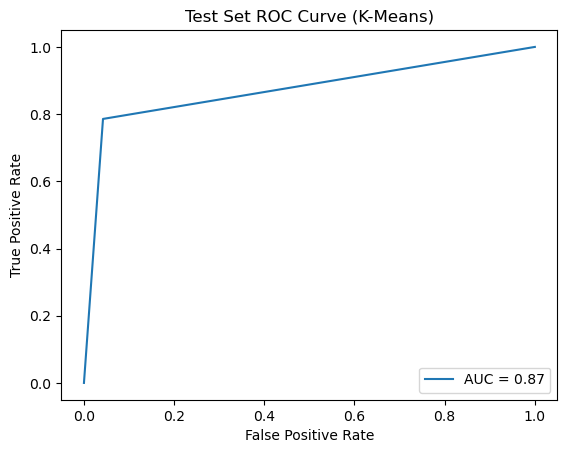

In [31]:
plot_roc_curve(y_test, y_pred_test, dataset='Test', 
                      learning='K-Means')

#### <a id='toc1_1_2_4_'></a>[(iv) Spectral Clustering](#toc0_)

Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. Use RBF kernel with $\gamma=1$ or find a $\gamma$ for which the two clusters have the
same balance as the one in original data set (if the positive class has $p$ and the negative class has $n$ samples, the two clusters must have $p$ and $n$ members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit_predict method.

In [32]:
clf, y_pred_train, y_pred_test = (None, )*3

columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
train_metrics, test_metrics = (pd.DataFrame(columns=columns), )*2

for i in range(30):
    # initialize spectral clustering
    clustering = SpectralClustering(n_clusters=k)
    
    # predict training set's response
    y_pred_train = clustering.fit_predict(X_train)
    
    # calculate training set's metrics
    (accuracy,
    precision,
    recall,
    f1,
    roc_auc) = calculate_metrics(y_train, y_pred_train)
    
    # add new row to train_metrics
    new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
                            columns=columns)
    train_metrics = pd.concat([train_metrics, new_row], ignore_index=True)
    
    # predict test set's metrics
    y_pred_test = clustering.fit_predict(X_test)
    
    # calculate training set's metrics
    (accuracy,
    precision,
    recall,
    f1,
    roc_auc) = calculate_metrics(y_test, y_pred_test)
    
    # add new row to train_metrics
    new_row = pd.DataFrame([[accuracy, precision, recall, f1, roc_auc]], 
                            columns=columns)
    test_metrics = pd.concat([test_metrics, new_row], ignore_index=True)
        
# display averages of each metric for test and train sets
averages_dict = {'Accuracy' : (train_metrics['accuracy'].mean(), 
                               test_metrics['accuracy'].mean()), 
                 'Precision' : (train_metrics['precision'].mean(), 
                               test_metrics['precision'].mean()),
                 'Recall' : (train_metrics['recall'].mean(), 
                               test_metrics['recall'].mean()),
                 'F1-Score' : (train_metrics['f1_score'].mean(), 
                               test_metrics['f1_score'].mean()),
                 'AUC' :      (train_metrics['roc_auc'].mean(), 
                               test_metrics['roc_auc'].mean())}
averages_df = pd.DataFrame(data=averages_dict, index=['Train', 'Test'])
averages_df.round(2)

,Accuracy,Precision,Recall,F1-Score,AUC
Train,0.63,1.0,0.01,0.01,0.50
Test,0.64,1.0,0.02,0.05,0.51


##### <a id='toc1_1_2_4_1_'></a>[Training Set](#toc0_)

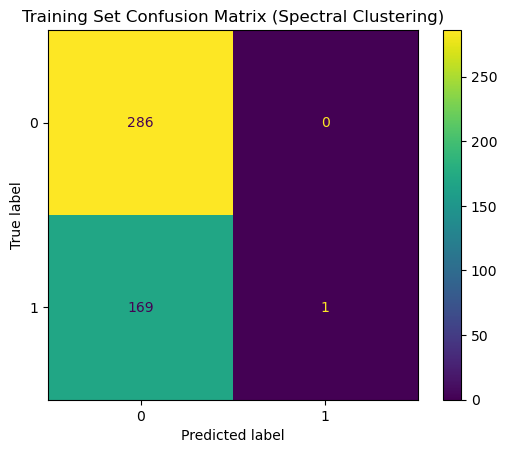

In [33]:
plot_confusion_matrix(y_train, y_pred_train,
                      dataset='Training', learning='Spectral Clustering')

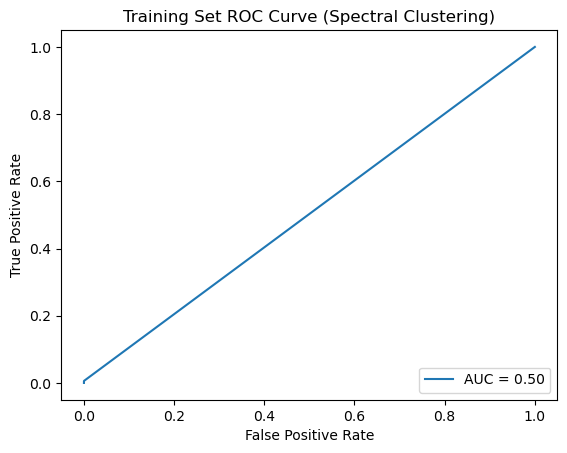

In [34]:
plot_roc_curve(y_train, y_pred_train,
              dataset='Training', learning='Spectral Clustering')

##### <a id='toc1_1_2_4_2_'></a>[Test Set](#toc0_)

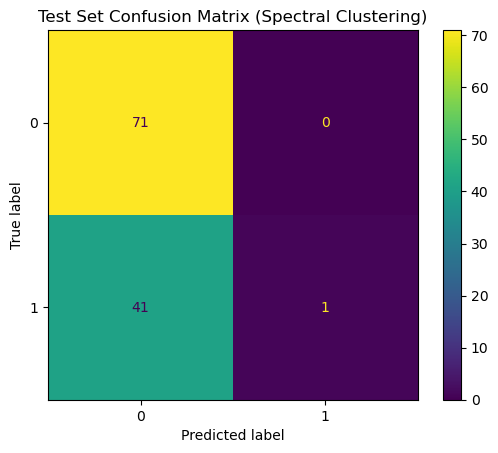

In [35]:
plot_confusion_matrix(y_test, y_pred_test, dataset='Test', 
                      learning='Spectral Clustering')

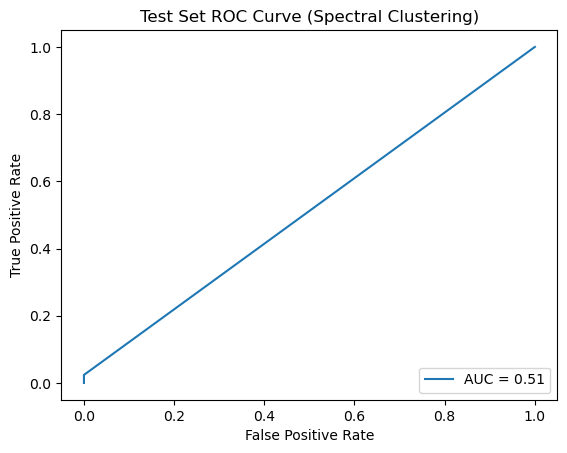

In [36]:
plot_roc_curve(y_test, y_pred_test, dataset='Test', 
                learning='Spectral Clustering')

#### <a id='toc1_1_2_5_'></a>[(iv) Compare](#toc0_)

One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.

- todo

<hr>

## <a id='toc1_2_'></a>[Active Learning Using Support Vector Machines](#toc0_)

### <a id='toc1_2_1_'></a>[(a) Download the banknote authentication Data Set](#toc0_)

Download the [Banknote Authentication Data Set](https://archive.ics.uci.edu/dataset/267/banknote+authentication). 

In [71]:
df = pd.read_csv(filepath_or_buffer='../data/data_banknote_authentication.txt', 
                 names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [72]:
training_set = df.sample(n=900)
test_set = df.sample(n=472)
X_train, y_train = training_set.iloc[:, :-1], training_set.iloc[:, -1]
X_test, y_test = test_set.iloc[:, :-1], test_set.iloc[:, -1]

# scale features
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))

In [73]:
assert(df.shape == (1372, 5))
assert(training_set.shape == (900, 5))
assert(test_set.shape == (472, 5))
assert(X_train.shape == (900, 4))
assert(y_train.shape == (900,))
assert(X_test.shape == (472, 4))
assert(y_test.shape == (472,))

### <a id='toc1_2_2_'></a>[(b) Repeat each of the following two procedures 50 times](#toc0_)

Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.


#### <a id='toc1_2_2_1_'></a>[(i) Passive](#toc0_)

1. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and $L_1$ penalty.
2. Select the penalty parameter using 5-fold cross validation.
3. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. 
   
      Do NOT replace the samples back into the training set at each step.
4. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented *passive learning*.

In [74]:
avg_test_error_dict = {}

for i in range(50):
    # store test errors calculated for the 90 SVMs in this iteration
    test_errors = np.array([])
    X_pool = pd.DataFrame(columns=X_train.columns)
    y_pool = pd.Series()
    
    # calculate test error for each of the 90 SVMs
    for j in range(90):
        # initialize pool of 10 randomly selected points from training set
        random_samples = X_train.sample(n=10)
        X_pool = pd.concat([X_pool, random_samples])
        y_pool = pd.concat([y_pool, y_train.iloc[random_samples.index]])
        
        # find L1 penalty using 5-fold cross-validation
        C = find_L1_penalty(LinearSVC(penalty='l1', dual=False), X_pool, y_pool)
        
        # train L1 penalized SVM. use penalty found from 5-fold cross-validation
        clf = LinearSVC(penalty='l1', dual=False, C=C)
        clf.fit(X_pool, y_pool)
        
        # calculate test error 
        y_pred_test = clf.predict(X_test)
        test_error = accuracy_score(y_test, y_pred_test)
        test_errors = np.append(test_errors, test_error)
    
    # average all test errors over 90 SVMs
    avg_test_error_dict[f'Iteration #{i + 1}'] = [round(np.mean(test_errors), 
                                                        3)]

avg_test_error_df = pd.DataFrame(data=avg_test_error_dict,
                                 index=['Average Test Error'])
display(avg_test_error_df)

,Iteration #1,Iteration #2,Iteration #3,Iteration #4,Iteration #5,Iteration #6,Iteration #7,Iteration #8,Iteration #9,Iteration #10,...,Iteration #41,Iteration #42,Iteration #43,Iteration #44,Iteration #45,Iteration #46,Iteration #47,Iteration #48,Iteration #49,Iteration #50
Average Test Error,0.983,0.991,0.984,0.991,0.989,0.993,0.984,0.992,0.984,0.991,...,0.984,0.985,0.988,0.991,0.991,0.989,0.988,0.991,0.992,0.988


#### <a id='toc1_2_2_2_'></a>[(ii) Active](#toc0_)

1. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and $L_1$ penalty.
2. Select the parameters of the SVM with 5-fold cross validation. 
3. Choose the 10 closest data points in the training set to the hyperplane of the SVM and add them to the pool.
   
      Do not replace the samples back into the training set.
4. Train a new SVM using the pool. 
5. Repeat this process until all training data is used.
   
      You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented *active learning*.

### <a id='toc1_2_3_'></a>[(c) Average the 50 test errors](#toc0_)